In [2]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import *
from keras.layers import BatchNormalization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
dataset_path = '/content/drive/MyDrive/datasets/emotion_detection/fer2013.csv'

In [25]:
num_classes = 7

In [26]:
def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y) #NORMALIZE
    return X, Y

In [ ]:
X, Y = getData(dataset_path)
num_class = len(set(Y))
print(num_class)

In [ ]:
print(X.shape)

In [ ]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [31]:

# Reshape each value from 1D(28709) to 3D(48,48,1)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = X_train.astype('float32')
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = X_test.astype('float32')

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

32298 train samples
3589 test samples


In [32]:
X_train.shape

(32298, 48, 48, 1)

In [33]:
width, height = 48, 48
batch_size = 64
num_features = 64

In [39]:
model = Sequential()
# channels_last for 2D data: (rows, cols, channels)/channels_first: for 2D data: (channels, rows, cols)
# 1st Convolutional Layer 
model.add(Conv2D(256, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# 2nd Convolutional Layer 
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 3rd Convolutional Layer 
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 4th Convolutional Layer 
model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 5th Convolutional Layer 
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 6th Convolutional Layer 
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#1st Dense Layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))

#2nd Dense Layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

#3rd Dense Layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))

#Output
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_27 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 46, 46, 256)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_28 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 46, 46, 256)      

In [40]:
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [41]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [42]:
dataGEN = data_generator.flow(X_train, y_train, batch_size)

In [43]:
epochs = 70
modelPath='/content/drive/MyDrive/datasets/emotion_detection/Models/Face_Expression_Classfication_6Conv_model.h5' # save model at this location after each epoch
history = model.fit( dataGEN,
                      steps_per_epoch=len(X_train) / batch_size,
                      epochs=epochs,
                      verbose=1, 
                      callbacks = [es, ModelCheckpoint(filepath=modelPath)],
                      validation_data=(X_test,y_test))

Epoch 1/70
504/504 [==============================] - 56s 108ms/step - loss: 1.6730 - accuracy: 0.3326 - val_loss: 1.7936 - val_accuracy: 0.3118
Epoch 2/70
504/504 [==============================] - 53s 105ms/step - loss: 1.3723 - accuracy: 0.4695 - val_loss: 1.2877 - val_accuracy: 0.5085
Epoch 3/70
504/504 [==============================] - 53s 104ms/step - loss: 1.2318 - accuracy: 0.5308 - val_loss: 1.5594 - val_accuracy: 0.4107
Epoch 4/70
504/504 [==============================] - 53s 106ms/step - loss: 1.1629 - accuracy: 0.5556 - val_loss: 1.4355 - val_accuracy: 0.4753
Epoch 5/70
504/504 [==============================] - 53s 106ms/step - loss: 1.1127 - accuracy: 0.5768 - val_loss: 1.1016 - val_accuracy: 0.5790
Epoch 6/70
504/504 [==============================] - 53s 106ms/step - loss: 1.0765 - accuracy: 0.5913 - val_loss: 1.0583 - val_accuracy: 0.5949
Epoch 7/70
504/504 [==============================] - 53s 105ms/step - loss: 1.0484 - accuracy: 0.6048 - val_loss: 1.2378 - val_ac

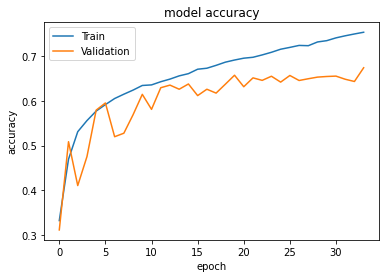

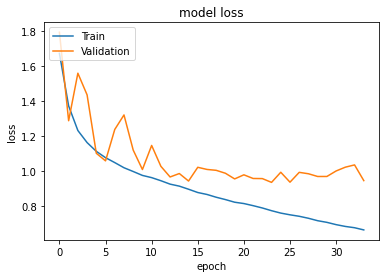

In [44]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
model.save('/content/drive/MyDrive/datasets/emotion_detection/Models/Face_Expression_Classfication_6Conv_backup_model.h5')

In [50]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/datasets/emotion_detection/Models/Face_Expression_Classfication_6Conv_model.h5')

In [48]:
datagen_validation = ImageDataGenerator(rescale = 1./255)
validation_data = datagen_validation.flow_from_directory("/content/drive/MyDrive/datasets/emotion_detection/test/",
                                                    target_size=(48, 48),
                                                    color_mode="grayscale",
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 7178 images belonging to 7 classes.


In [ ]:
CNN_Predictions = loaded_model.predict(validation_data)
# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(validation_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix Model 3', fontsize=20, fontweight='bold')